In [14]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [15]:

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.eval()

target_layer = model.layer4[-1]

In [ ]:
img_path = '../../dataset/Test/red-rust/flipped_1_H-86_jpg.rf.4293c81f2f070b79736423e4ff27c2b4.jpg'
image = Image.open(img_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
input_tensor = transform(image).unsqueeze(0)

In [17]:
grads = []
features = []

def save_grad(grad):
    grads.append(grad)

def forward_hook(module, input, output):
    features.append(output)
    output.register_hook(save_grad)

handle = target_layer.register_forward_hook(forward_hook)

output = model(input_tensor)
pred_class = output.argmax().item()

model.zero_grad()
output[0, pred_class].backward()

In [18]:
grad = grads[0][0].detach().numpy()         
feature = features[0][0].detach().numpy()     

weights = np.mean(grad, axis=(1, 2))        
cam = np.zeros(feature.shape[1:], dtype=np.float32)  

for i, w in enumerate(weights):
    cam += w * feature[i]

cam = np.maximum(cam, 0)  
cam = cv2.resize(cam, (224, 224))
cam -= np.min(cam)
cam /= np.max(cam)

img_np = np.array(image.resize((224, 224)))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
overlay = heatmap + np.float32(img_np) / 255
overlay = overlay / np.max(overlay)

this is using: <bound method Module._get_name of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0)

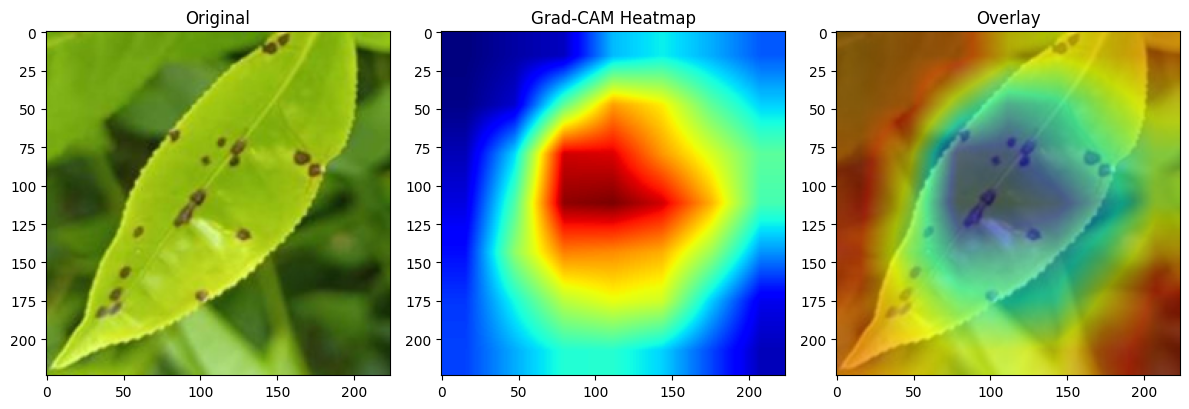

In [19]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_np)
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(cam, cmap='jet')
plt.title("Grad-CAM Heatmap")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title("Overlay")

plt.tight_layout()
print('this is using:', model._get_name)
plt.show()

handle.remove()
